# Horse Racing Data Analysis


I initially got interested in looking at horse race betting through a behavioral economics lens. According to research on human behavior, people tend to make riskier bets later in the race day to try and recover from any losses throughout the day. Since horse odds shift with betting behavior, the “riskier” horses don’t have as good of a payout once everyone starts betting on them, so it’s actually more advantageous to go against the grain and bet on low risk horses at the end of the day. With this background, I became interested in analyzing what makes a horse more likely to win, whether that be its race odds, country of origin, or position around the track. I got the data from Kraggle on thoroughbred racing in Hong Kong.

In this data analysis I will answer the following questions:

Q1: How does winning percentage/average finishing ranking vary by hourse country? How have these metrics changed over time?
Q2: How does positioning throughout sections of the race correlate to the final outcome? Do positions stay relatively constant throughout the race?
Q3: How accurate are the win odds to determine the outcome?
Q4: Which jockeys consistently perform well regardless of the odds set against them

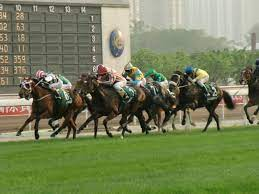

## Data quality check / cleaning / preparation

I started with doing some initial data cleaning and preparation. I looked for the number of missing values (null counts), the number of unique values, and the frequencies of the top values. This gave me insights into the data distribution, such as common values and data completeness. I combined these statistics into a single DataFrame for a consolidated view of the data analysis.





In [2]:
#...Table for distribution of variables...#

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# read in data and look at columns
races = pd.read_csv('races.csv')
races.head(5)


,race_id,date,venue,race_no,config,surface,distance,going,horse_ratings,prize,...,place_combination3,place_combination4,place_dividend1,place_dividend2,place_dividend3,place_dividend4,win_combination1,win_dividend1,win_combination2,win_dividend2
0,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,...,6.0,NaN,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN
1,1,1997-06-02,ST,2,A,0,1200,GOOD TO FIRM,40-15,485000.0,...,4.0,NaN,12.5,47.0,33.5,NaN,5,23.5,NaN,NaN
2,2,1997-06-02,ST,3,A,0,1400,GOOD TO FIRM,60-40,625000.0,...,13.0,NaN,23.0,23.0,59.5,NaN,11,70.0,NaN,NaN
3,3,1997-06-02,ST,4,A,0,1200,GOOD TO FIRM,120-95,1750000.0,...,10.0,NaN,14.0,24.5,16.0,NaN,5,52.0,NaN,NaN
4,4,1997-06-02,ST,5,A,0,1600,GOOD TO FIRM,60-40,625000.0,...,1.0,NaN,15.5,28.0,17.5,NaN,2,36.5,NaN,NaN


In [48]:
runs = pd.read_csv('runs.csv')
runs.head(5)

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,time2,time3,time4,time5,time6,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,...,21.59,23.86,24.62,NaN,NaN,83.92,9.7,3.7,118,2
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,...,21.99,23.30,23.70,NaN,NaN,83.56,16.0,4.9,164,57
2,0,3,858,7,0.0,4.75,3,NZ,Gelding,60,...,21.59,23.90,24.22,NaN,NaN,83.40,3.5,1.5,137,18
3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,60,...,21.83,23.70,24.00,NaN,NaN,83.62,39.0,11.0,80,59
4,0,5,2796,6,0.0,3.75,3,GB,Gelding,60,...,21.75,23.22,23.50,NaN,NaN,83.24,50.0,14.0,9,154


In [46]:
# define fields of interest for each dataset
runs_interest_cols = runs[['position_sec1', 'position_sec2', 'position_sec3', 'position_sec4', 'result', 'won', 'win_odds', 'horse_country', 'jockey_id']]
races_interest_cols = races[['date', 'race_id']]

# compute null counts, unique counts, and frequencies for fields of interest in 'runs' dataset
run_null_counts = runs_interest_cols.apply(lambda x: x.isnull().sum())
run_unique_counts = runs_interest_cols.apply(lambda x: x.nunique())
run_freqs = runs_interest_cols.apply(lambda x: x.value_counts().head().to_dict())

# compute null counts, unique counts, and frequencies for fields of interest in 'races' dataset
race_null_counts = races_interest_cols[['date', 'race_id']].apply(lambda x: x.isnull().sum())
race_unique_counts = races_interest_cols.apply(lambda x: x.nunique())
race_freqs = races_interest_cols.apply(lambda x: x.value_counts().head().to_dict())

# aggregate null counts, unique counts, and frequencies for both datasets in a dataframe
pd.DataFrame({'# of Unique Values': pd.concat([run_unique_counts, race_unique_counts]), '# of Missing Values': pd.concat([run_null_counts, race_null_counts]), 'Frequency of Top Levels': pd.concat([run_freqs, race_freqs])})

,# of Unique Values,# of Missing Values,Frequency of Top Levels
position_sec1,14,0,"{1: 6341, 2: 6339, 6: 6336, 3: 6335, 5: 6335}"
position_sec2,14,0,"{2: 6343, 3: 6343, 4: 6341, 1: 6341, 5: 6339}"
position_sec3,14,0,"{3: 6351, 1: 6350, 4: 6347, 2: 6345, 6: 6338}"
position_sec4,14,33221,"{4.0: 3648, 3.0: 3636, 1.0: 3636, 2.0: 3634, 6..."
result,14,0,"{4: 6366, 1: 6360, 3: 6359, 2: 6348, 6: 6343}"
won,2,0,"{0.0: 73087, 1.0: 6360}"
win_odds,180,0,"{99.0: 7502, 10.0: 2679, 11.0: 2482, 12.0: 230..."
horse_country,16,2,"{'AUS': 29906, 'NZ': 27497, 'IRE': 10473, 'GB'..."
jockey_id,186,0,"{2: 4719, 64: 4381, 18: 3985, 63: 3767, 34: 3590}"
date,683,0,"{'2000-09-17': 11, '1998-02-01': 11, '2001-10-..."
